In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from keras import layers
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Maximum,Flatten
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose,UpSampling2D
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D,MaxPooling3D,AveragePooling2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.utils import class_weight
from keras.models import Sequential
import nibabel as nib
import numpy as np 
import pandas as pd 
import os

In [2]:
path1 = '/content/drive/MyDrive/tumordetection/Dataset/survival_info.csv'

In [3]:
import csv

age_dict = {}
days_dict = {}

with open(path1, mode='r') as csv_file:
    csv_reader = csv.reader(csv_file,delimiter = ',')
    line_count = 0
    a = 0
    b = 0
    c = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            print(row)
            key = row[0]
            age = row[1]
            days = row[2]
            age_dict[key] = float(age)
            days_dict[key] = int(days)
            if int(days) < 250:
                a += 1
            elif (int(days) >= 250 and int(days) <= 500):
                b += 1
            else:
                c += 1
            line_count+=1

    print(f'Processed {line_count} lines.')
    #age_m = np.zeros((1,1))
    print(a,b,c)

Column names are Brats20ID, Age, Survival_days, Extent_of_Resection
['BraTS20_Training_001', '60.463', '289', 'GTR']
['BraTS20_Training_002', '52.263', '616', 'GTR']
['BraTS20_Training_003', '54.301', '464', 'GTR']
['BraTS20_Training_004', '39.068', '788', 'GTR']
['BraTS20_Training_005', '68.493', '465', 'GTR']
['BraTS20_Training_006', '67.126', '269', 'GTR']
['BraTS20_Training_007', '69.912', '503', 'GTR']
['BraTS20_Training_008', '68.285', '1278', 'NA']
['BraTS20_Training_009', '56.419', '1155', 'GTR']
['BraTS20_Training_010', '48.367', '515', 'GTR']
['BraTS20_Training_011', '60.942', '421', 'NA']
['BraTS20_Training_012', '65.899', '495', 'GTR']
['BraTS20_Training_013', '59.693', '698', 'GTR']
['BraTS20_Training_014', '51.734', '359', 'GTR']
['BraTS20_Training_015', '62.614', '169', 'GTR']
['BraTS20_Training_016', '55.759', '368', 'GTR']
['BraTS20_Training_017', '58.258', '439', 'GTR']
['BraTS20_Training_018', '61.605', '486', 'GTR']
['BraTS20_Training_019', '68.049', '287', 'GTR']
[

In [4]:
def SurvPredNet(input_img,age_m):
    #input_img = BatchNormalization()(input_img)
    a1 = Conv2D(16,kernel_size = (3,3) , padding='same')(input_img)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    
    a1 = MaxPooling2D(pool_size = (2,2) , strides = (2,2))(a1)
    
    a1 = Conv2D(24,kernel_size = (3,3) , padding='same')(a1)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    
    a1 = MaxPooling2D(pool_size = (2,2) , strides = (2,2))(a1)
    
    a1 = Conv2D(32,kernel_size = (3,3) , padding='same')(a1)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    
    a1 = MaxPooling2D(pool_size = (2,2) , strides = (2,2))(a1)
    
    a1 = Conv2D(32,kernel_size = (3,3) , padding='same')(a1)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    
    a1 = MaxPooling2D(pool_size = (2,2) , strides = (2,2))(a1)
    
    a1 = Conv2D(32,kernel_size = (3,3) , padding='same')(a1)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    
    a1 = AveragePooling2D(pool_size = (6,6) , strides = (1,1))(a1)
    
    a1 = Conv2D(32,kernel_size = (3,3) , padding = 'same')(a1)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    
    a1 = AveragePooling2D(pool_size = (5,5) , strides = (1,1))(a1)
    a1 = Conv2D(32,kernel_size = (3,3) , padding = 'same')(a1)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    
    a1 = AveragePooling2D(pool_size = (6,6) , strides = (1,1))(a1)
    
    a1 = Flatten()(a1)
    a1 = concatenate([a1,age_m])
    a1 = BatchNormalization()(a1)
    
    a1 = Dense(32,activation = 'relu')(a1)
    a1 = Dense(16,activation = 'relu')(a1)
    outputs = Dense(3,activation = 'softmax')(a1)
    
    model = Model(inputs = [input_img,age_m] , outputs = outputs)
    
    return model

In [5]:
input_img = Input((240,240,5))
age_m = Input((1))
model = SurvPredNet(input_img,age_m)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 5) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 240, 16) 736         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 240, 240, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 240, 240, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
path = '/content/drive/MyDrive/tumordetection/Dataset/BraTS20_HGG/'
all_images = os.listdir(path)
#print(len(all_images))
all_images.sort()

def standardize(image):

  standardized_image = np.zeros(image.shape)

  #
 
      # iterate over the `z` dimension
  for z in range(image.shape[2]):
      # get a slice of the image
      # at channel c and z-th dimension `z`
      image_slice = image[:,:,z]

      # subtract the mean from image_slice
      centered = image_slice - np.mean(image_slice)
     
      # divide by the standard deviation (only if it is different from zero)
      if(np.std(centered)!=0):
          centered = centered/np.std(centered)

      # update  the slice of standardized image
      # with the scaled centered and scaled image
      standardized_image[:, :, z] = centered

  ### END CODE HERE ###

  return standardized_image

In [7]:
cnt = 0
for image_num in range(170):
    image1 = all_images[image_num]
    if image1 in days_dict:
        cnt += 1
        
print(cnt)

149


In [10]:
loss_hist = []
accu_hist = []
epoch_wise_loss = []
epoch_wise_accu = []
#for epochs in range(45):
epoch_loss = 0
epoch_accu = 0
input_to_model = np.zeros((149,240,240,5))
age = np.zeros((149,1))
ground_truth = np.zeros((149,3))

In [11]:
cnt = 0
for image_num in range(170):
    #print(epochs)
    #print("image_num ",image_num)
    #print("cnt" ,cnt)
    data = np.zeros((240,240,155,4))
    image_data2=np.zeros((240,240,155))

    # data preprocessing starts here

    x = all_images[image_num]
    
    if x in days_dict:
        #print(cnt)
        #print(x)
        folder_path = path + '/' + x;
        modalities = os.listdir(folder_path)
        modalities.sort()
        #data = []
        w = 0
        for j in range(len(modalities)):
          #print(modalities[j])

          image_path = folder_path + '/' + modalities[j]
          if not(image_path.find('seg.nii') == -1):
            img = nib.load(image_path);
            image_data2 = img.get_data()
            image_data2 = np.asarray(image_data2)
            #print("Entered ground truth")
          else:
            img = nib.load(image_path);
            image_data = img.get_data()
            image_data = np.asarray(image_data)
            image_data = standardize(image_data)
            data[:,:,:,w] = image_data
            #print("Entered modality")
            w = w+1

        #print(data.shape)
        #print(image_data2.shape)
        image_data2[image_data2 == 4] = 3

        input_to_model[cnt,:,:,:4] = data[:,:,75,:]
        input_to_model[cnt,:,:,4] = image_data2[:,:,75]
        #age = np.zeros((1,1))
        age[cnt,0] = float(age_dict[x])
        days = int(days_dict[x])
        

        #ground_truth = np.zeros((1,3))
        #print(age[cnt,0])

        if int(days) < 300:
            ground_truth[cnt,0] = 1
        elif (int(days) >= 300 and int(days) <= 450):
            ground_truth[cnt,1] = 1
        else:
            ground_truth[cnt,2] = 1 
        
        #print(ground_truth[cnt])
        cnt += 1
        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


In [12]:
history = model.fit(x=[input_to_model,age],y=ground_truth, epochs = 60 , batch_size = 64)
print(history.history['loss'])

Epoch 1/60
3/3 [==============================] - 8s 2s/step - loss: 1.2341 - accuracy: 0.3600
Epoch 2/60
3/3 [==============================] - 7s 2s/step - loss: 1.0397 - accuracy: 0.4656
Epoch 3/60
3/3 [==============================] - 7s 2s/step - loss: 0.9400 - accuracy: 0.5494
Epoch 4/60
3/3 [==============================] - 7s 2s/step - loss: 0.8888 - accuracy: 0.6058
Epoch 5/60
3/3 [==============================] - 7s 2s/step - loss: 0.8569 - accuracy: 0.6115
Epoch 6/60
3/3 [==============================] - 7s 2s/step - loss: 0.8160 - accuracy: 0.6132
Epoch 7/60
3/3 [==============================] - 7s 2s/step - loss: 0.7339 - accuracy: 0.7489
Epoch 8/60
3/3 [==============================] - 7s 2s/step - loss: 0.6980 - accuracy: 0.8031
Epoch 9/60
3/3 [==============================] - 7s 2s/step - loss: 0.6483 - accuracy: 0.8036
Epoch 10/60
3/3 [==============================] - 7s 2s/step - loss: 0.5880 - accuracy: 0.8559
Epoch 11/60
3/3 [==============================] 

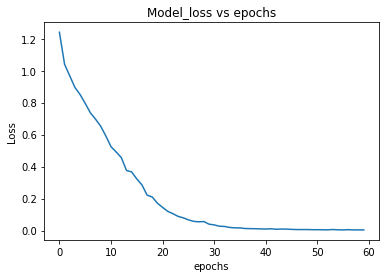

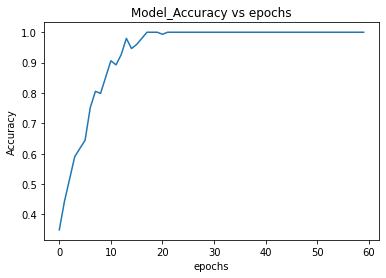

In [15]:
model.save('/content/drive/MyDrive/tumordetection/surv_pred3.h5')
 
plt.plot(history.history['loss'])
plt.title('Model_loss vs epochs')
plt.ylabel('Loss')
plt.xlabel('epochs')

plt.show()

plt.plot(history.history['accuracy'])
plt.title('Model_Accuracy vs epochs')
plt.ylabel('Accuracy')
plt.xlabel('epochs')

plt.show()